In [ ]:
!pip install tbats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tbats import TBATS
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **Thực hiện thuật toán theo tỉ lệ 8:2 (80% train : 20% test)**

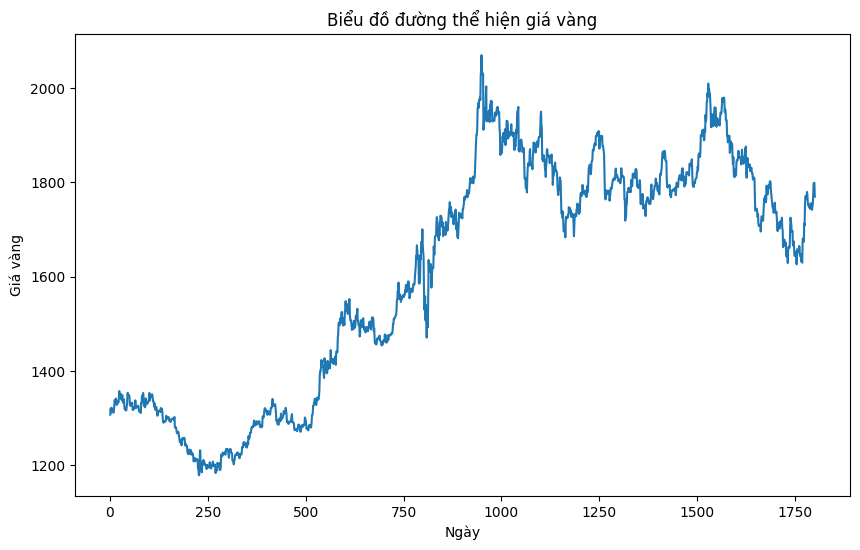

In [112]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_data_gold = df_gold.iloc[:1800]
test_data_gold = df_gold.iloc[1800:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()

In [119]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500 ngày đều là đường thẳng tăng, 250 ngày thì đường cong có tính mùa vụ
# Kiểm định ta được 250 có RMSE: 163.9176 , MAPE: 7.4878 %, MAE: 148.2162
# Kiểm định không có tính mùa vụ ta được RMSE: 74.5590 , MAPE: 2.8487 %, MAE: 55.6673
# Như vậy có thể thấy dữ liệu không có tính mùa vụ và đường thẳng có kết quả khả quan hơn

test_data_gold = df_gold.iloc[1800:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])
forecast = model.forecast(steps=452)

test_data_gold.insert(1, "Price Predict", forecast)

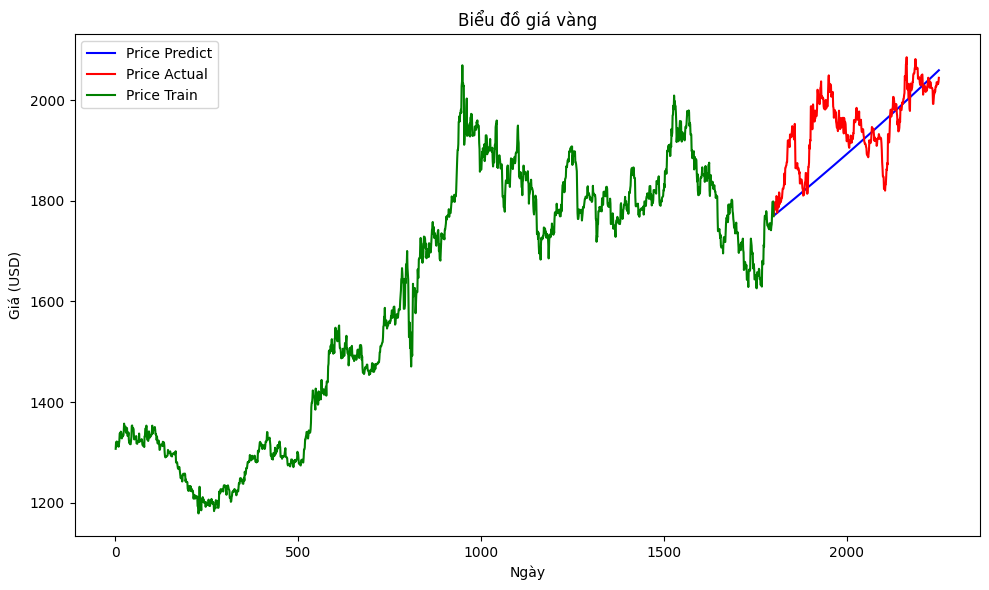

In [120]:
plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Day Number'], test_data_gold['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_gold['Day Number'], test_data_gold['Price'], label='Price Actual', color='red')
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

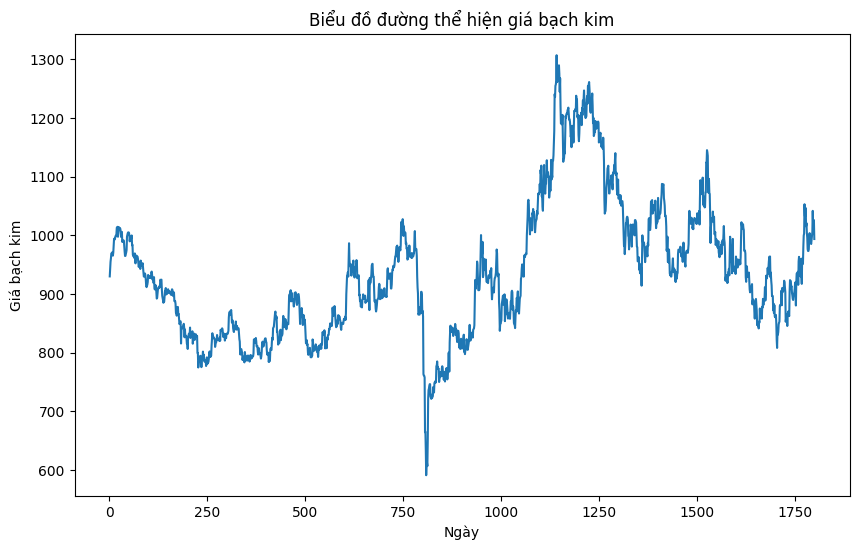

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:1800]
test_data_platium = df_platium.iloc[1800:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

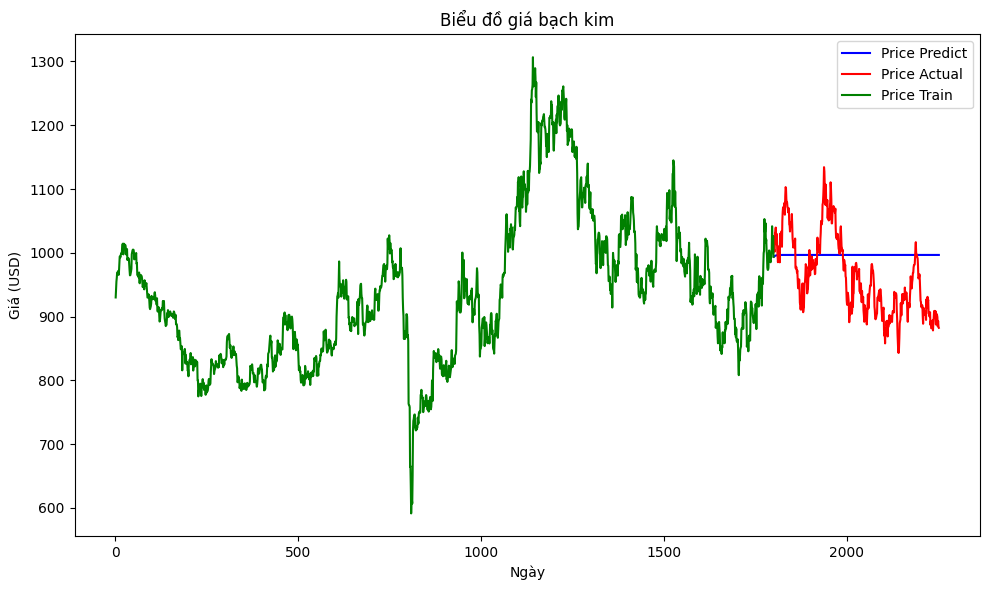

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 125, 200 ngày ko đều có kết quả là đường thẳng ngang, 250 ngày là dường cong
# Như vậy, nhận thấy dữ liệu không có tính mùa vụ, đường thẳng dự báo ra kết quả khả quan hơn
test_data_platium = df_platium.iloc[1800:]
estimator = TBATS(
#     seasonal_periods=[365],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])
forecast = model.forecast(steps=452)

test_data_platium.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Day Number'], test_data_platium['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_platium['Day Number'], test_data_platium['Price'], label='Price Actual', color='red')
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

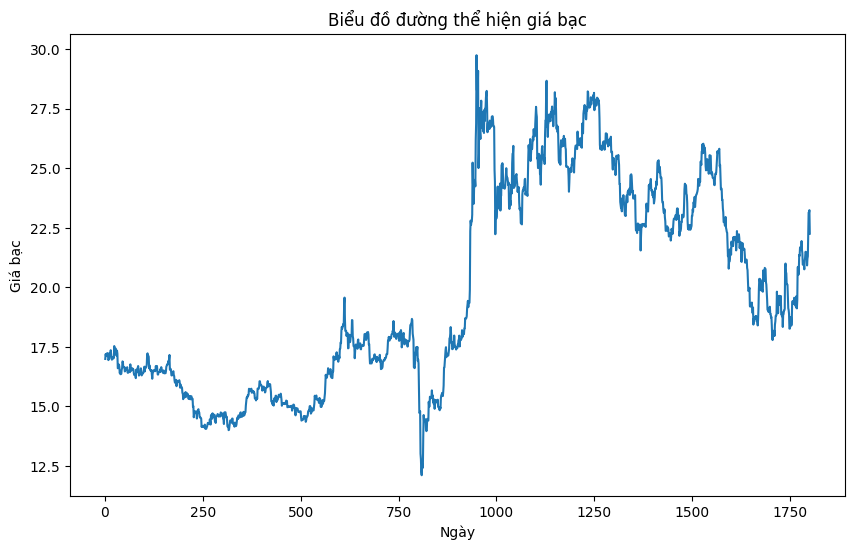

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_platium['Date'])
df_silver['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:1800]
test_data_silver = df_silver.iloc[1800:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

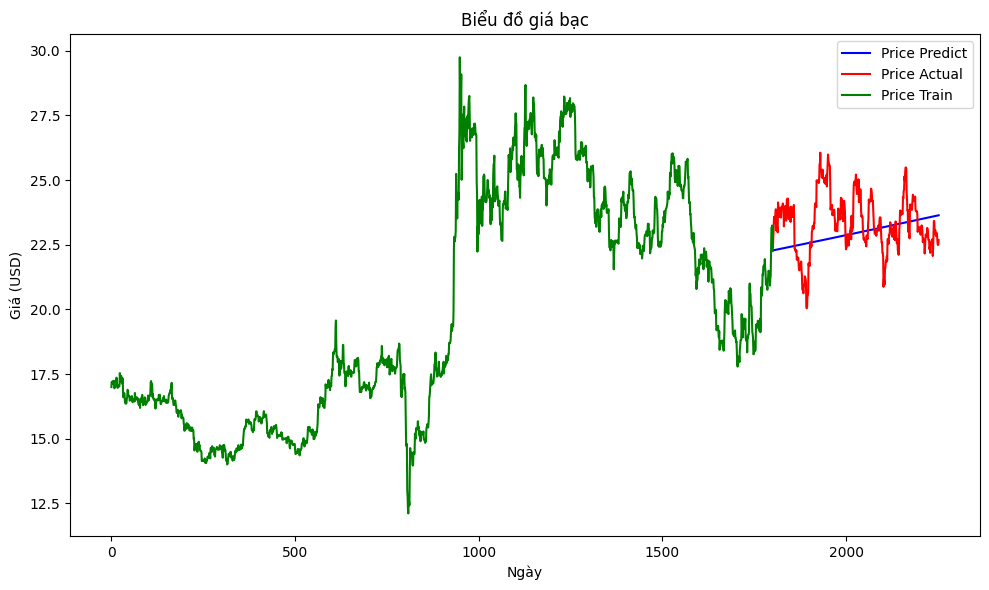

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 200, 250 ngày đều là đường thẳng tăng,
# Như vậy, dữ liệu không có tính mùa vụ, đường thẳng tăng cho ra kết quả khả quan hơn
test_data_silver = df_silver.iloc[1800:]
estimator = TBATS(
#     seasonal_periods=[30],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])
forecast = model.forecast(steps=452)

test_data_silver.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Day Number'], test_data_silver['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_silver['Day Number'], test_data_silver['Price'], label='Price Actual', color='red')
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 74.55896402774505
MAPE: 2.848659187799756%
MAE: 55.667360823392556


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 69.61037201441903
MAPE: 6.3966321708108325%
MAE: 60.35127402719297


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 1.2388127759572376
MAPE: 4.255830097705299%
MAE: 1.0043974879791888


# **Thực hiện thuật toán theo tỉ lệ 7:3 (70% train : 30% test)**

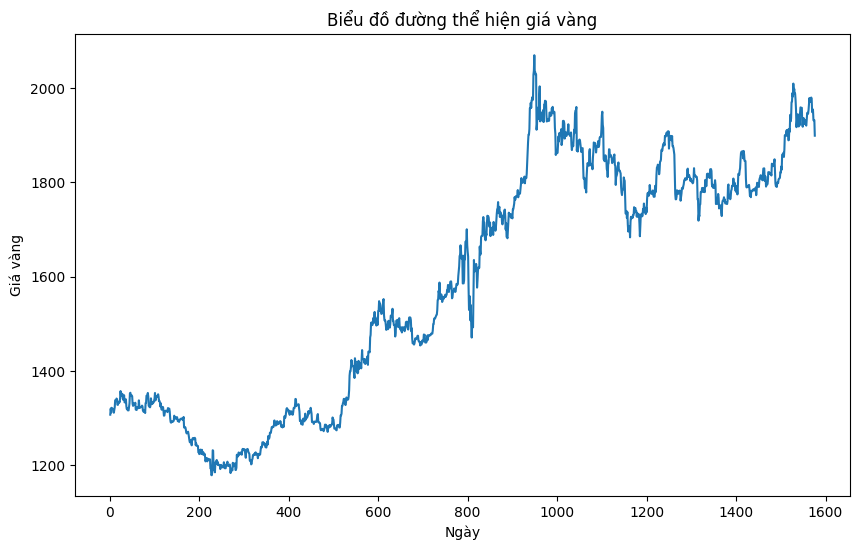

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_data_gold = df_gold.iloc[:1576]
test_data_gold = df_gold.iloc[1576:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()



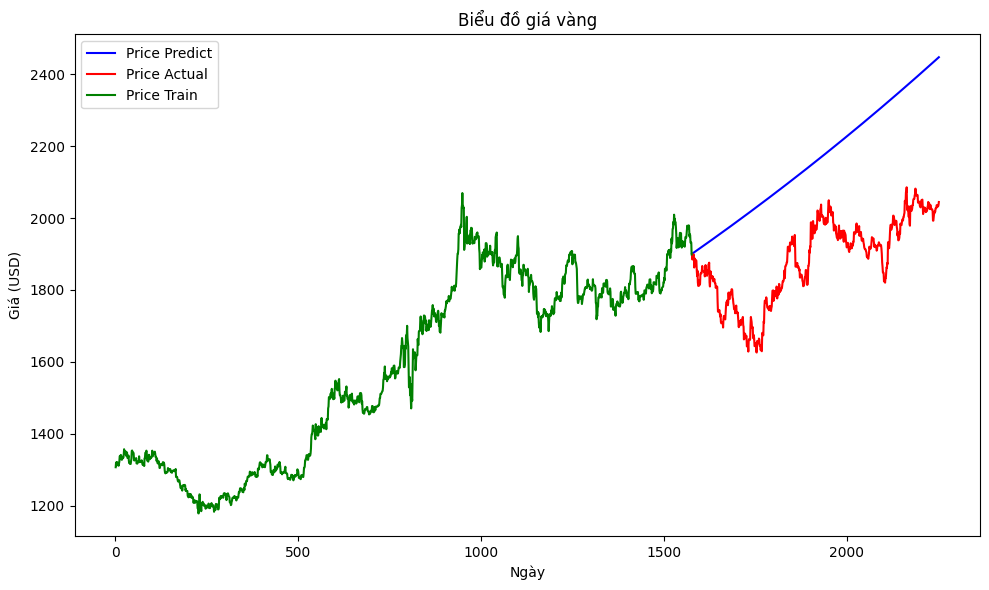

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500, 250 ngày đều là đường thẳng tăng
# Như vậy có thể thấy dữ liệu không có tính mùa vụ và đường thẳng có kết quả khả quan hơn
test_data_gold = df_gold.iloc[1576:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])
forecast = model.forecast(steps=676)

test_data_gold.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Day Number'], test_data_gold['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_gold['Day Number'], test_data_gold['Price'], label='Price Actual', color='red')
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

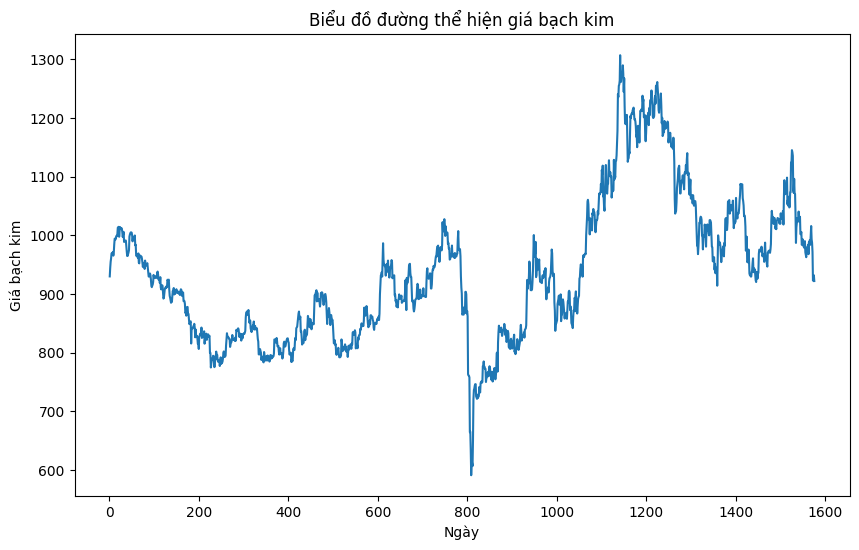

In [109]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:1576]
test_data_platium = df_platium.iloc[1576:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

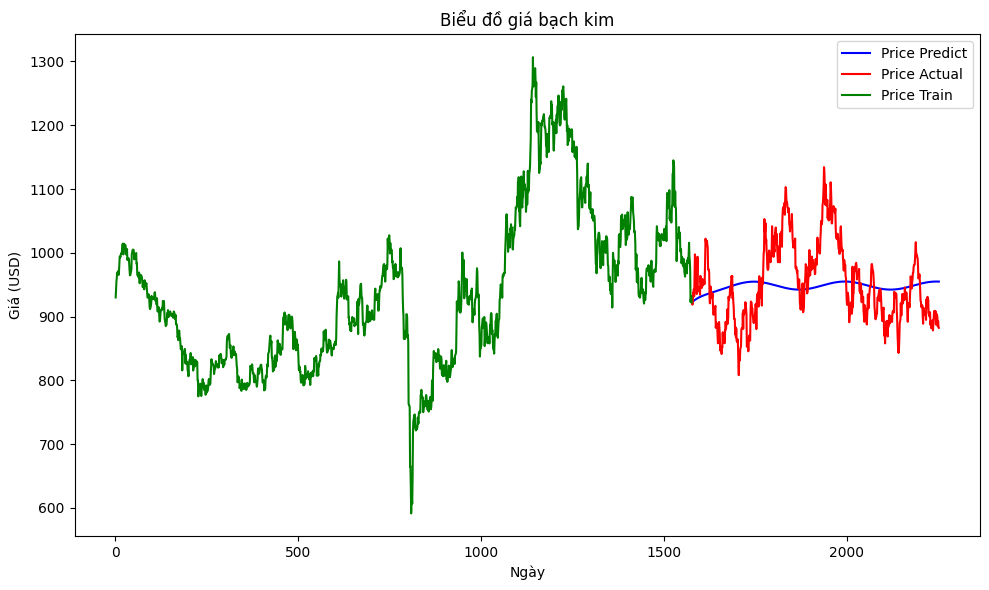

In [110]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90 ngày đều có kết quả là đường thẳng ngang, 365 ngày là dường cong giống với Test, 125, 200 ngày quá cong, 250 ngày cong nhẹ
# Kiểm định ta được 365 có RMSE: 85.5628, MAPE: 7.4635 %, MAE: 72.8456
# Kiểm định ta được 125 có RMSE: 63.6129 , MAPE: 5.3263 %, MAE: 51.2513
# Kiểm định ta được 200 có RMSE: 69.3315 , MAPE: 5.3583 %, MAE: 52.9023
# Kiểm định ta được 250 có RMSE: 61.2094 , MAPE: 5.1933 %, MAE: 49.8644
# Kiểm định không có tính mùa vụ ta được RMSE: 66.7945 , MAPE: 5.17589 %, MAE: 50.9171
# Tuy ta quan sát thấy chu kỳ 365 ngày dự báo ra kết quả có hình giống chu kỳ Test nhất nhưng chu kỳ 250 ngày khả quan hơn

test_data_platium = df_platium.iloc[1576:]
estimator = TBATS(
     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])
forecast = model.forecast(steps=676)

test_data_platium.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Day Number'], test_data_platium['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_platium['Day Number'], test_data_platium['Price'], label='Price Actual', color='red')
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

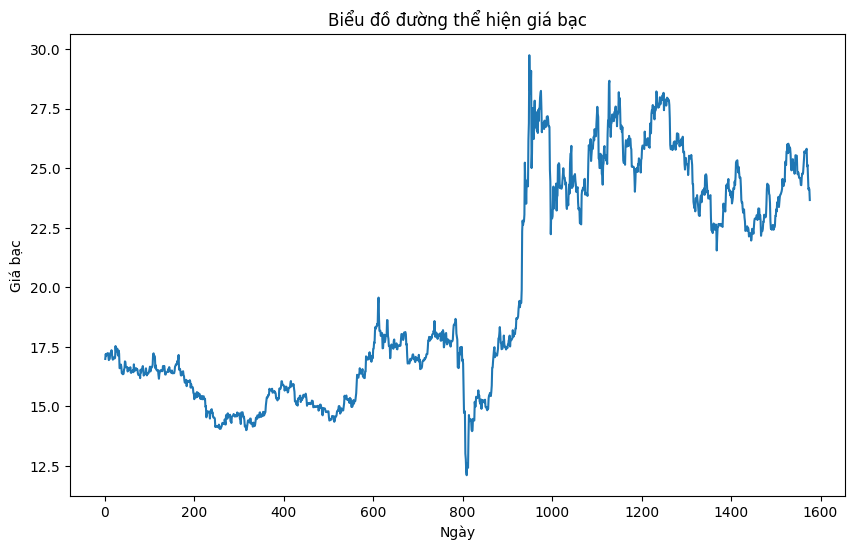

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver['Day Number'] = df_silver['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:1576]
test_data_silver = df_silver.iloc[1576:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

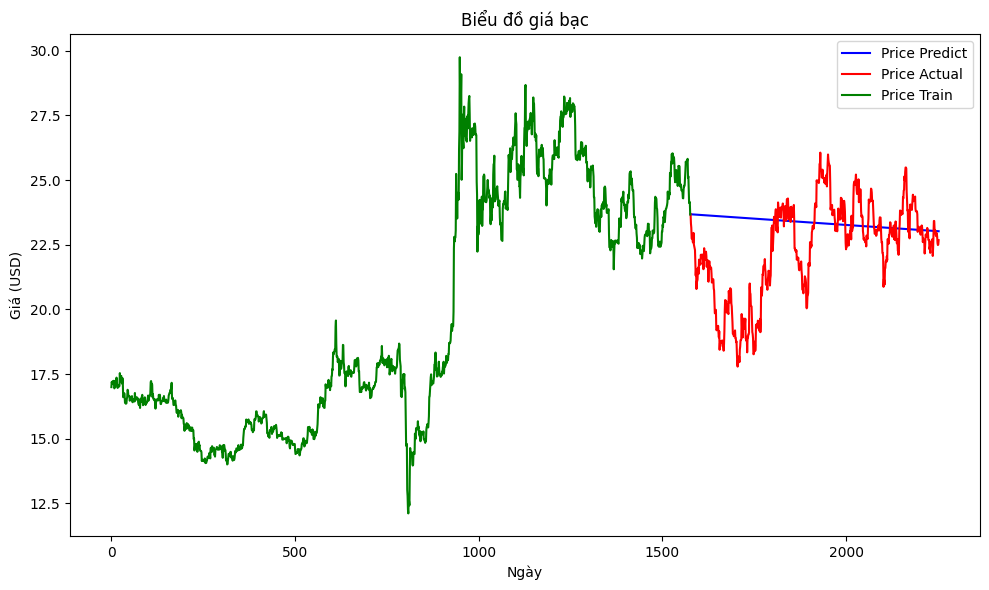

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 200, 250 ngày đều là đường thẳng tăng
# Như vậy, dữ liệu không có tính mùa vụ


test_data_silver = df_silver.iloc[1576:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])
forecast = model.forecast(steps=676)

test_data_silver.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Day Number'], test_data_silver['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_silver['Day Number'], test_data_silver['Price'], label='Price Actual', color='red')
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 295.4949724873322
MAPE: 14.774571929999118%
MAE: 277.627919027184


In [111]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 61.20942485816539
MAPE: 5.193304481262183%
MAE: 49.86435154358941


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 2.2064358762888623
MAPE: 7.795068222575107%
MAE: 1.61896552517051


# **Thực hiện thuật toán theo tỉ lệ 9:1 (90% train : 10% test)**

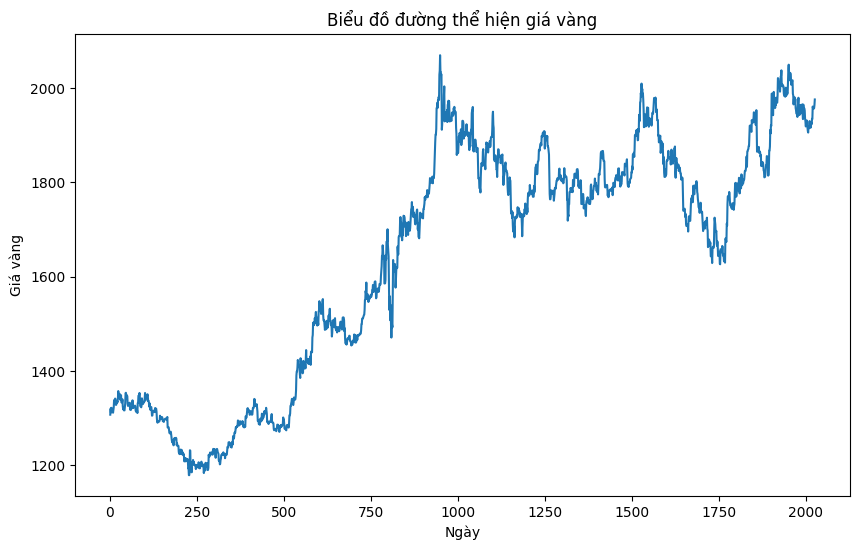

In [ ]:
df_gold = pd.read_csv(r'/content/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_gold['Day Number'] = df_gold['Date'].rank(method='dense').astype(int)
df_gold.columns = ['Date', 'Price', 'Day Number']

train_data_gold = df_gold.iloc[:2026]
test_data_gold = df_gold.iloc[226:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'])
plt.title('Biểu đồ đường thể hiện giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.show()


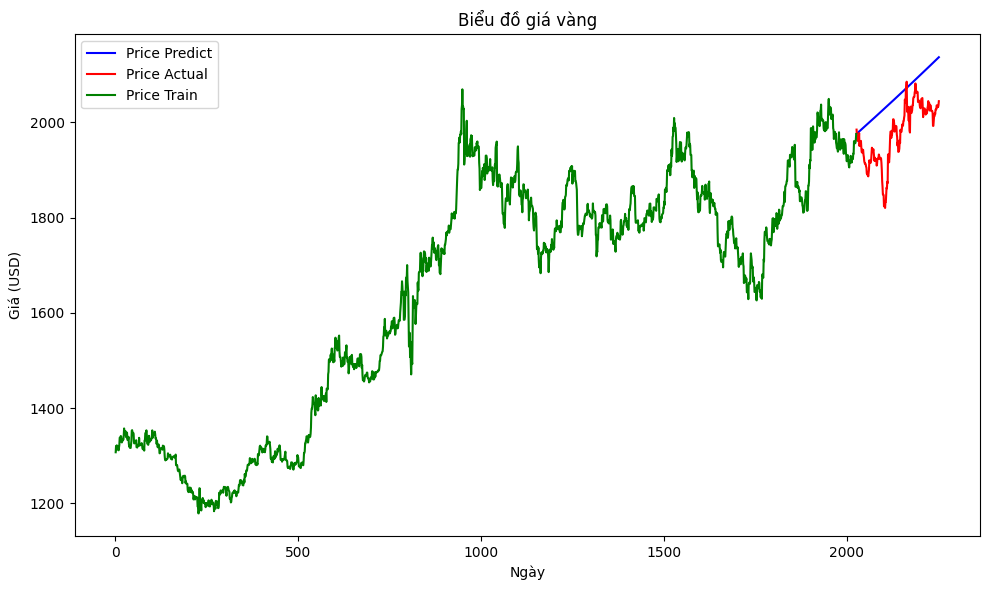

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử các giá trị như 7 ngày, 90, 365, 200, 249, 251, 500, 250 ngày đều là đường thẳng tăng
# Như vậy có thể thấy dữ liệu không có tính mùa vụ
test_data_gold = df_gold.iloc[2026:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_gold['Price'])
forecast = model.forecast(steps=226)

test_data_gold.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_gold['Day Number'], test_data_gold['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_gold['Day Number'], test_data_gold['Price'], label='Price Actual', color='red')
plt.plot(train_data_gold['Day Number'], train_data_gold['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá vàng')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

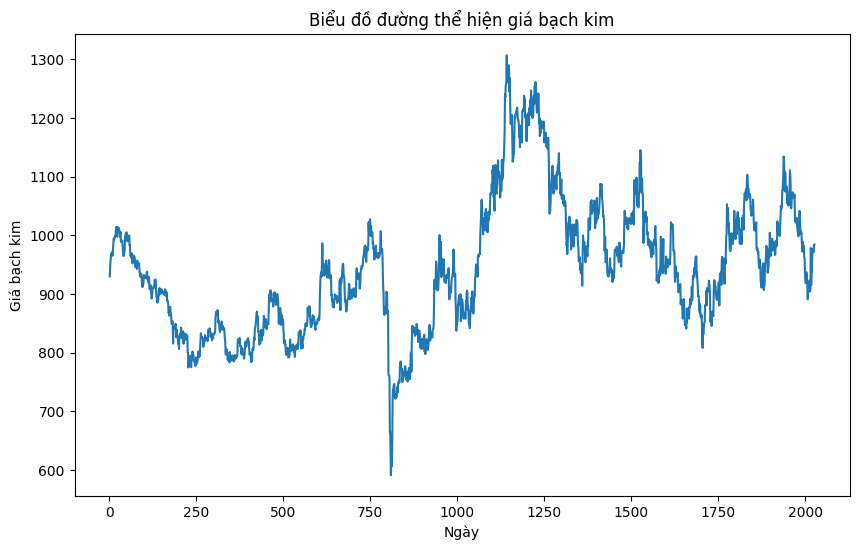

In [ ]:
df_platium = pd.read_csv(r'/content/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
df_platium['Day Number'] = df_platium['Date'].rank(method='dense').astype(int)
df_platium.columns = ['Date', 'Price', 'Day Number']

train_data_platium = df_platium.iloc[:2026]
test_data_platium = df_platium.iloc[2026:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'])
plt.title('Biểu đồ đường thể hiện giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá bạch kim')
plt.show()

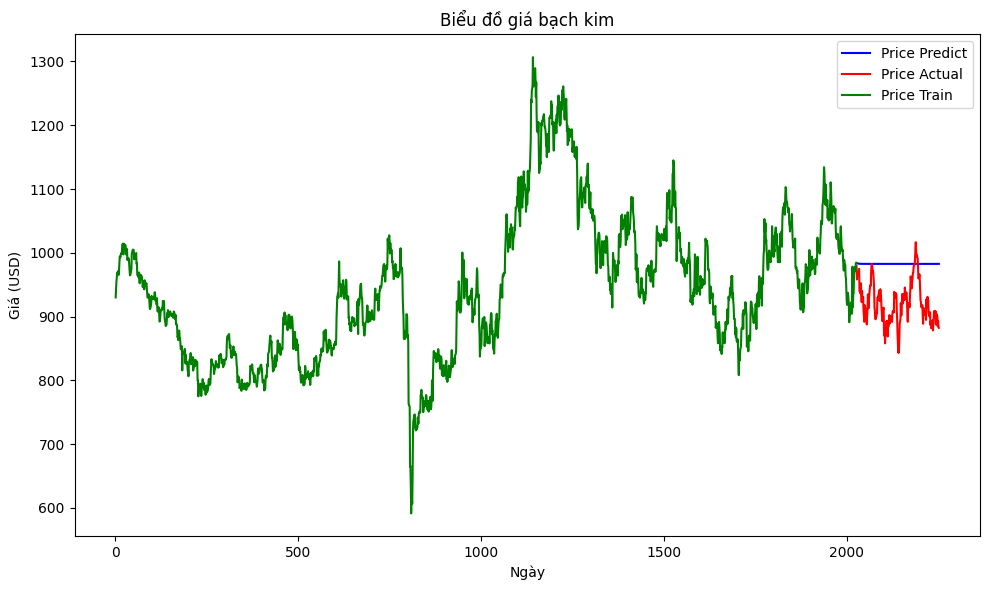

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 125, 200 ngày ko đều có kết quả là đường thẳng ngang, 365, 200, 250 ngày là dường cong
# Kiểm định ta được 365 có RMSE: 154.4166 , MAPE: 15.1638 %, MAE: 138.3864
# Kiểm định ta được 200 có RMSE: 78.3823 , MAPE: 7.7287 %, MAE: 70.0342
# Kiểm định ta được 200 có RMSE: 78.3823 , MAPE: 7.7287 %, MAE: 70.0342
# Kiểm định ta được 250 có RMSE: 72.3362 , MAPE: 7.1714 %, MAE: 64.9917
# Kiểm định không có tính mùa vụ ta được RMSE: 69.1791 , MAPE: 6.8824 %, MAE: 62.3236
# Tuy đã xuất hiện một số đường chu kỳ đáng chú ý trong dự đoán nhưng khả quan nhất là dữ liệu này không có tính mùa vụ

test_data_platium = df_platium.iloc[2026:]
estimator = TBATS(
#     seasonal_periods=[250],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_platium['Price'])
forecast = model.forecast(steps=226)

test_data_platium.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_platium['Day Number'], test_data_platium['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_platium['Day Number'], test_data_platium['Price'], label='Price Actual', color='red')
plt.plot(train_data_platium['Day Number'], train_data_platium['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạch kim')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

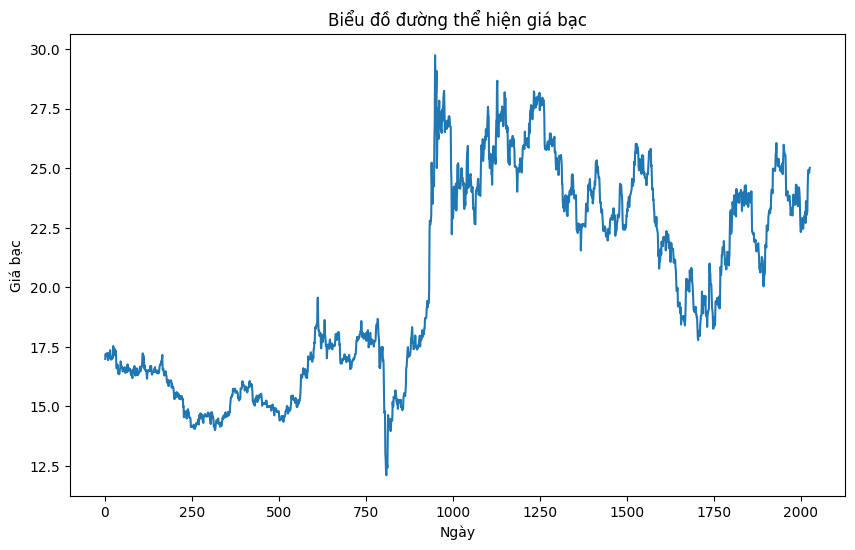

In [ ]:
df_silver = pd.read_csv(r'/content/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_silver['Day Number'] = df_silver['Date'].rank(method='dense').astype(int)
df_silver.columns = ['Date', 'Price', 'Day Number']

train_data_silver = df_silver.iloc[:2026]
test_data_silver = df_silver.iloc[2026:]

plt.figure(figsize=(10, 6))
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'])
plt.title('Biểu đồ đường thể hiện giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá bạc')
plt.show()

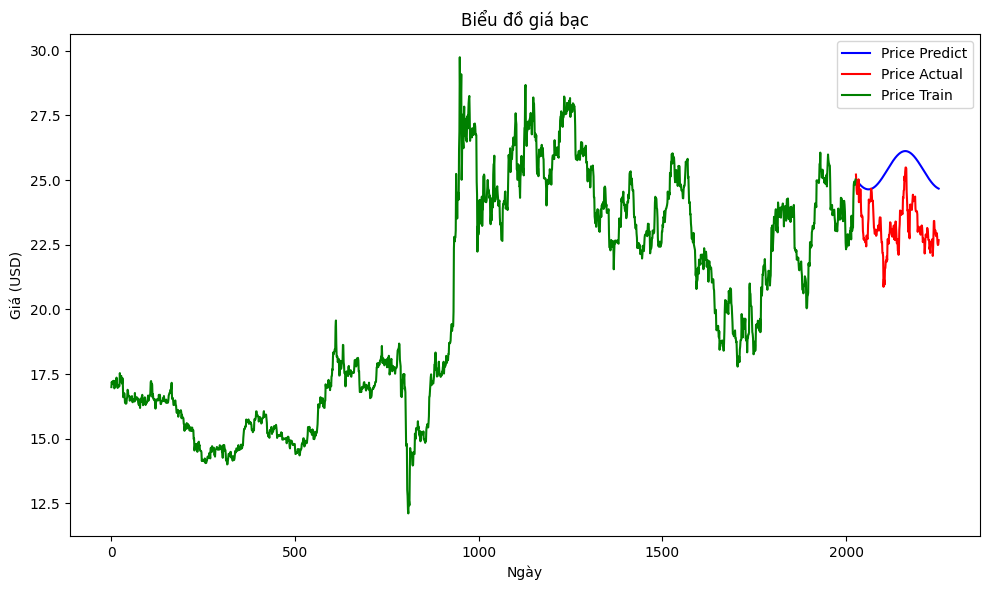

In [ ]:
# Nhận thấy dữ liệu không có tính mùa vụ rõ ràng, thử giá trị 7, 30, 90, 365, 250 ngày đều là đường thẳng tăng, 200 ngày là đường cong
# Kiểm định ta được 200 có RMSE: 2.2427 , MAPE: 8.9646 %, MAE: 2.0555
# Kiểm định không có tính mùa vụ ta được RMSE: 3.0936 , MAPE: 12.5022 %, MAE: 2.8690
# Như vậy, dữ liệu với chu kỳ 200 ngày cho ra kết quả khả quan hơn


test_data_silver = df_silver.iloc[2026:]
estimator = TBATS(
    seasonal_periods=[200],
    use_arma_errors=True
    ,use_box_cox=True
    ,use_trend=True
)
model = estimator.fit(train_data_silver['Price'])
forecast = model.forecast(steps=226)

test_data_silver.insert(1, "Price Predict", forecast)

plt.figure(figsize=(10, 6))

plt.plot(test_data_silver['Day Number'], test_data_silver['Price Predict'], label='Price Predict', color='blue')
plt.plot(test_data_silver['Day Number'], test_data_silver['Price'], label='Price Actual', color='red')
plt.plot(train_data_silver['Day Number'], train_data_silver['Price'], label='Price Train', color='green')

plt.title('Biểu đồ giá bạc')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình với dữ liệu giá vàng
actual_gold = test_data_gold['Price'].values
predict_gold = test_data_gold['Price Predict'].values

rmse_gold = np.sqrt(mean_squared_error(actual_gold, predict_gold))
mape_gold = np.mean(np.abs((actual_gold - predict_gold) / actual_gold)) * 100
mae_gold = mean_absolute_error(actual_gold, predict_gold)

print(f'RMSE: {rmse_gold}')
print(f'MAPE: {mape_gold}%')
print(f'MAE: {mae_gold}')

RMSE: 89.19794060371618
MAPE: 4.068637455964355%
MAE: 79.49403681401887


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạch kim
actual_platium = test_data_platium['Price'].values
predict_platium = test_data_platium['Price Predict'].values

rmse_platium = np.sqrt(mean_squared_error(actual_platium, predict_platium))
mape_platium = np.mean(np.abs((actual_platium - predict_platium) / actual_platium)) * 100
mae_platium = mean_absolute_error(actual_platium, predict_platium)

print(f'RMSE: {rmse_platium}')
print(f'MAPE: {mape_platium}%')
print(f'MAE: {mae_platium}')

RMSE: 69.17910930054958
MAPE: 6.882394417299126%
MAE: 62.323629476922704


In [ ]:
# Đánh giá mô hình với dữ liệu giá bạc
actual_silver = test_data_silver['Price'].values
predict_silver = test_data_silver['Price Predict'].values

rmse_silver = np.sqrt(mean_squared_error(actual_silver, predict_silver))
mape_silver = np.mean(np.abs((actual_silver - predict_silver) / actual_silver)) * 100
mae_silver = mean_absolute_error(actual_silver, predict_silver)

print(f'RMSE: {rmse_silver}')
print(f'MAPE: {mape_silver}%')
print(f'MAE: {mae_silver}')

RMSE: 2.242679594598679
MAPE: 8.964586068153686%
MAE: 2.0555367948614243
